In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import h5py

%load_ext autoreload
%autoreload 2

In [ ]:
def plot_training_chart(history, key, figsize=None):
  figsize = figsize or (10, 5)
  epochs = [i for i in history.epoch]
  fig , ax = plt.subplots(1, 1, figsize=figsize)
  for mt in ['picker_P', 'picker_S', 'detector']:
    train_metrics = history.history[f'{mt}_{key}']
    val_metrics = history.history['val_' + f'{mt}_{key}']
    ax.plot(epochs , train_metrics,'--', label = f'train {mt} {key}')
    ax.plot(epochs , val_metrics, label = f'val {mt} {key}')
  ax.set_title(f'Training & validation {key}')
  ax.legend()
  ax.set_xlabel("Epochs")
  ax.set_ylabel(f"{key}")
  plt.show()

def plot_stream(dset, p, s, eq, 
                is_test=False, thres=.5, 
                figsize=None):
  fig, ax = plt.subplots(4 if is_test else 3,1, figsize=(figsize))
  plt.tight_layout()

  for i in range(3):
    ymin, ymax = ax[i].get_ylim()
    xtr = ax[i].get_xaxis_transform()  
    ax[i].plot(np.array(dset)[:,i], 'k')
    ax[i].vlines(dset.attrs['p_arrival_sample'], ymin, ymax, color='b', transform=xtr, label='P-arrival')
    ax[i].vlines(dset.attrs['s_arrival_sample'], ymin, ymax, color='r', transform=xtr, label='S-arrival')
    ax[i].vlines(dset.attrs['coda_end_sample'], ymin, ymax, color='aqua', transform=xtr, label='Coda End')
    ax[i].set_xticklabels([])
    ax[i].set_ylabel('Amplitude')
    plt.tight_layout()
    if i==0:
      ax[i].set_title(ev)

  if is_test:
    p_p,s_p,eq_p = p.copy(), s.copy(), eq.copy()
    p_p[p_p<thres] = 0
    s_p[s_p<thres] = 0
    eq_p[eq_p<thres] = 0

    ax[3].plot(p_p, 'b--', label='P_arrival')
    ax[3].plot(s_p, 'r--', label='S_arrival')
    ax[3].plot(eq_p, 'g--', label='Earthquake')
    ax[3].set_ylabel('Probability')
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=3)
    plt.tight_layout()


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Eq_Detection

/content/drive/MyDrive/Colab Notebooks/Eq_Detection


In [ ]:
!ls

 architecture.drawio		  'Laporan Kelompok 2 - EQ - DL.docx'
 data				   model_eqt.ipynb
 download_data.ipynb		  'modeling v2.ipynb'
 EQTransformer			   modules
 Ganjar_EQ_Test_hdf5.ipynb	  '[rimba] modeling.ipynb'
'Kelompok Earthquake DL.gslides'   transformer_eq_scratch.py


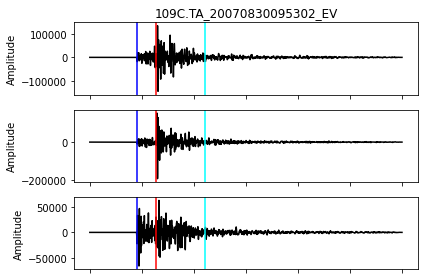

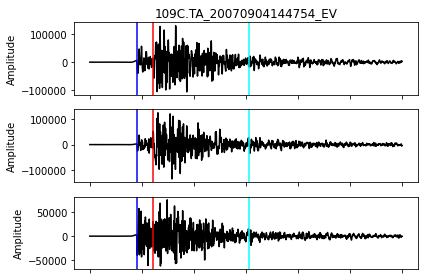

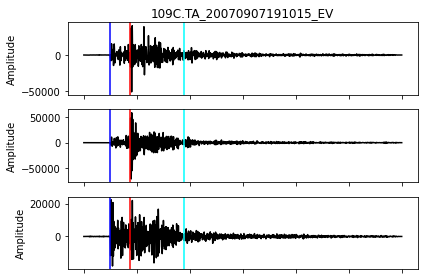

In [ ]:
csv_path = os.path.join('data','chunk2_ev.1069.csv')
h5_path = os.path.join('data','chunk2_ev.1069.hdf5')
metadata = pd.read_csv(csv_path)
ev_list = metadata['trace_name'].to_list()

h5 = h5py.File(h5_path, 'r')
for ev in ev_list[:3]:
  dset = h5.get(f'data/{ev}')
  times = np.array(dset.attrs['times'])
  p = dset.attrs['p_arrival_sample']
  s = dset.attrs['s_arrival_sample']
  eq = dset.attrs['coda_end_sample']
  
  plot_stream(dset, p, s, eq)

  # export an event as a csv
  # p_time = dset.attrs['p_arrival_sample'].astype(int)
  # coda_time = dset.attrs['coda_end_sample'][0][0].astype(int)

  # y_ = np.zeros((len(times),))
  # y_[p_time:coda_time+1] = 1
  # y_

  # dfd = {'timestamp': times, 'is_eq': y_.astype(int)}
  # for i,c in enumerate(['HHE', 'HHN', 'HHZ']):
  #   dfd[c] = np.array(dset)[:,i]

  # out_path = os.path.join('data', 'csv', f'{ev}.csv')
  # pd.DataFrame(dfd).to_csv(out_path, index=None)

In [ ]:
TIMESTEPS = 6000

X, label_p, label_s, label_eq = [], [], [], []

for ev in ev_list:
    dset = h5.get(f'data/{ev}')

    X.append(np.array(dset))

    y_ = np.zeros((TIMESTEPS,))
    time_p = dset.attrs['p_arrival_sample'].astype(int)
    y_[time_p] = 1.0
    label_p.append(y_.astype(int))

    y_ = np.zeros((TIMESTEPS,))
    y_[dset.attrs['s_arrival_sample'].astype(int)] = 1.0
    label_s.append(y_.astype(int))
        
    y_ = np.zeros((TIMESTEPS,))
    y_[time_p:dset.attrs['coda_end_sample'][0][0].astype(int)+1] = 1.0
    label_eq.append(y_.astype(int))

X = np.array(X)
label_p = np.expand_dims(label_p, axis=-1)
label_s = np.expand_dims(label_s, axis=-1)
label_eq = np.expand_dims(label_eq, axis=-1)

train_size = int(len(X)*.8)
X_train, X_test = X[:train_size], X[train_size:]
p_train, p_test = label_p[:train_size], label_p[train_size:]
s_train, s_test = label_s[:train_size], label_s[train_size:]
eq_train, eq_test = label_eq[:train_size], label_eq[train_size:]

In [ ]:
np.array(dset)

array([[ -26.071047,   65.739395,  -25.37143 ],
       [ -26.12999 ,   81.015274,  -23.984709],
       [ -27.481735,   91.5151  ,  -27.204847],
       ...,
       [ 118.409424, -410.28247 ,  139.44383 ],
       [  80.39939 , -248.48502 ,  120.00895 ],
       [-208.45552 ,  654.84314 , -219.7775  ]], dtype=float32)

# Model

In [ ]:
import tensorflow as tf
from modules.models import SimplifiedEQModel

input = tf.keras.layers.Input(shape=(6000, 3))
conv1 = tf.keras.layers.Conv1D(32, (2,), padding='same', activation='relu')(input)
maxp1 = tf.keras.layers.MaxPooling1D(2)(conv1)
conv2 = tf.keras.layers.Conv1D(32, (2,), padding='same', activation='relu')(maxp1)
maxp2 = tf.keras.layers.MaxPooling1D(2)(conv2)
conv3 = tf.keras.layers.Conv1D(32, (2,), padding='same', activation='relu')(maxp2)
maxp3 = tf.keras.layers.MaxPooling1D(2)(conv3)
conv4 = tf.keras.layers.Conv1D(32, (2,), padding='same', activation='relu')(maxp3)
maxp4 = tf.keras.layers.MaxPooling1D(2)(conv4)
conv5 = tf.keras.layers.Conv1D(32, (2,), padding='same', activation='relu')(maxp4)
maxp5 = tf.keras.layers.MaxPooling1D(3)(conv5)
bnorm = tf.keras.layers.BatchNormalization()(maxp5)

lstm_s = tf.keras.layers.LSTM(32, return_sequences=True)(bnorm)
lstm_p = tf.keras.layers.LSTM(32, return_sequences=True)(bnorm)

up_s1 = tf.keras.layers.UpSampling1D(3)(lstm_s)
conv_s1 = tf.keras.layers.SeparableConv1D(16, (2,), padding='same', activation='relu')(up_s1)
up_s2 = tf.keras.layers.UpSampling1D(2)(conv_s1)
conv_s2 = tf.keras.layers.SeparableConv1D(8, (2,), padding='same', activation='relu')(up_s2)
up_s3 = tf.keras.layers.UpSampling1D(2)(conv_s2)
conv_s3 = tf.keras.layers.SeparableConv1D(4, (2,), padding='same', activation='relu')(up_s3)
up_s4 = tf.keras.layers.UpSampling1D(2)(conv_s3)
conv_s4 = tf.keras.layers.SeparableConv1D(2, (2,), padding='same', activation='relu')(up_s4)
up_s5 = tf.keras.layers.UpSampling1D(2)(conv_s4)
conv_s6 = tf.keras.layers.SeparableConv1D(1, (2,), padding='same', activation='sigmoid', name='picker_S')(up_s5)

up_p1 = tf.keras.layers.UpSampling1D(3)(lstm_p)
conv_p1 = tf.keras.layers.SeparableConv1D(16, (2,), padding='same', activation='relu')(up_p1)
up_p2 = tf.keras.layers.UpSampling1D(2)(conv_p1)
conv_p2 = tf.keras.layers.SeparableConv1D(8, (2,), padding='same', activation='relu')(up_p2)
up_p3 = tf.keras.layers.UpSampling1D(2)(conv_p2)
conv_p3 = tf.keras.layers.SeparableConv1D(4, (2,), padding='same', activation='relu')(up_p3)
up_p4 = tf.keras.layers.UpSampling1D(2)(conv_p3)
conv_p4 = tf.keras.layers.SeparableConv1D(2, (2,), padding='same', activation='relu')(up_p4)
up_p5 = tf.keras.layers.UpSampling1D(2)(conv_p4)
conv_p6 = tf.keras.layers.SeparableConv1D(1, (2,), padding='same', activation='sigmoid', name='picker_P')(up_p5)

up_d1 = tf.keras.layers.UpSampling1D(3)(bnorm)
conv_d1 = tf.keras.layers.SeparableConv1D(16, (2,), padding='same', activation='relu')(up_d1)
up_d2 = tf.keras.layers.UpSampling1D(2)(conv_d1)
conv_d2 = tf.keras.layers.SeparableConv1D(8, (2,), padding='same', activation='relu')(up_d2)
up_d3 = tf.keras.layers.UpSampling1D(2)(conv_d2)
conv_d3 = tf.keras.layers.SeparableConv1D(4, (2,), padding='same', activation='relu')(up_d3)
up_d4 = tf.keras.layers.UpSampling1D(2)(conv_d3)
conv_d4 = tf.keras.layers.SeparableConv1D(2, (2,), padding='same', activation='relu')(up_d4)
up_d5 = tf.keras.layers.UpSampling1D(2)(conv_d4)
conv_d6 = tf.keras.layers.SeparableConv1D(1, (2,), padding='same', activation='sigmoid', name='detector')(up_d5)


model = tf.keras.models.Model(inputs=input, outputs=[conv_d6, conv_s6, conv_p6])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6000, 3)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 6000, 32)     224         ['input_1[0][0]']                
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 3000, 32)     0           ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 3000, 32)     2080        ['max_pooling1d[0][0]']          
                                                                                              

In [ ]:
!pip -q install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.4 MB/s eta 0:00:00


In [ ]:
import tensorflow_addons as tfa

f1_score = tfa.metrics.F1Score(num_classes=2, average='macro', threshold=0.5, name='f1')
loss = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss=loss, optimizer=optimizer)

In [ ]:
hist = model.fit(X_train, [eq_train, p_train, s_train], epochs=2, batch_size=32, validation_split=0.1)

Epoch 1/2
25/25 [==============================] - 20s 805ms/step - loss: 1.7207 - detector_loss: 0.6771 - picker_S_loss: 0.6137 - picker_P_loss: 0.4299 - val_loss: 1.5808 - val_detector_loss: 0.7152 - val_picker_S_loss: 0.5685 - val_picker_P_loss: 0.2970
Epoch 2/2
25/25 [==============================] - 22s 866ms/step - loss: 1.2896 - detector_loss: 0.6687 - picker_S_loss: 0.4662 - picker_P_loss: 0.1546 - val_loss: 1.0710 - val_detector_loss: 0.7129 - val_picker_S_loss: 0.3100 - val_picker_P_loss: 0.0480


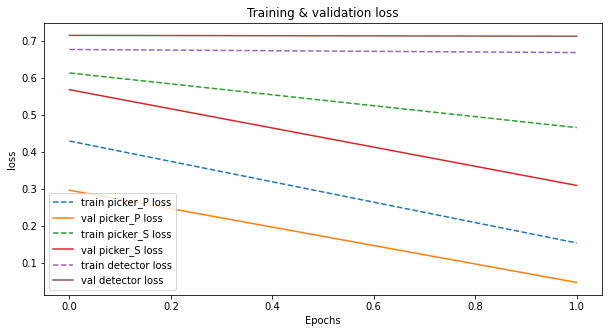

In [ ]:
plot_training_chart(hist, 'loss')

7/7 [==============================] - 6s 157ms/step


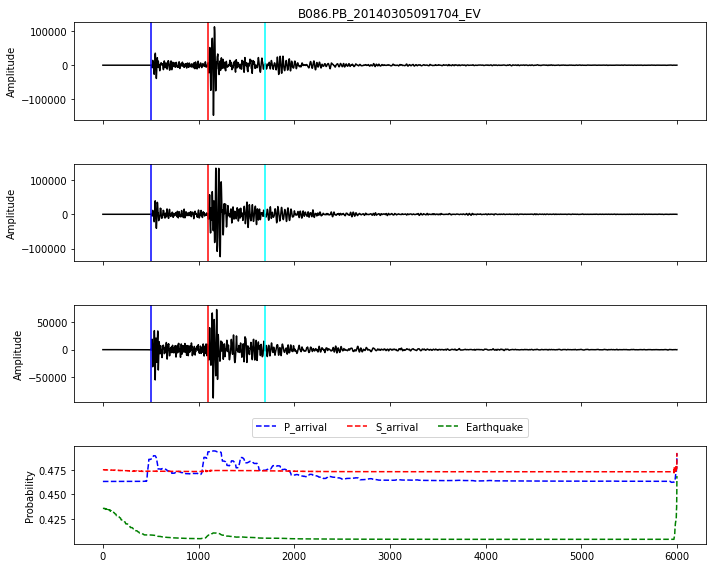

In [ ]:
p_pred_1_1, s_pred_1_1, eq_pred_1_1 = model.predict(X_test)

i_test = train_size + 72

dset = h5.get(f'data/{ev_list[i_test]}')
it = i_test-train_size
p = np.squeeze(p_pred_1_1, axis=2)[it]
s = np.squeeze(s_pred_1_1, axis=2)[it]
eq = np.squeeze(eq_pred_1_1, axis=2)[it]

plot_stream(dset, p, s, eq, is_test=True, thres=.3, figsize=(10,8))

### Tunning Hyperparameter
 - lstm_blocks: 1, dense_blocks: 1
 - lstm_blocks: 1, dense_blocks: 2
 - lstm_blocks: 2, dense_blocks: 2
 - lstm_blocks: 2, dense_blocks: 2

l_block = 1, dense_block = 1

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10) 
lstm_1_1 = model_LSTM(lstm_blocks=1, dense_blocks=1)

class_weights = {
    'P': {0: .11, 1: .89}, 
    'S': {0: .11, 1: .89}, 
    'Eq': {0: .2, 1: .8}
    }
hist_1_1 = lstm_1_1.fit(X_train, [p_train, s_train, eq_train], epochs=50, batch_size=128, 
                validation_split=0.1, callbacks=[es])

In [ ]:
plot_training_chart(hist_1_1, 'loss')

In [ ]:
lstm_1_1.evaluate(X_test, [p_test, s_test, eq_test])

In [ ]:
p_pred_1_1, s_pred_1_1, eq_pred_1_1 = lstm_1_1.predict(X_test)

In [ ]:
i_test = train_size + 8

dset = h5.get(f'data/{ev_list[i_test]}')
it = i_test-train_size
p = np.squeeze(p_pred_1_1, axis=2)[it]
s = np.squeeze(s_pred_1_1, axis=2)[it]
eq = np.squeeze(eq_pred_1_1, axis=2)[it]

plot_stream(dset, p, s, eq, is_test=True, thres=.3, figsize=(10,8))

In [ ]:
lstm_1_1.save('lstm_l1_d1.h5')

In [ ]:
np.mean(np.absolute(p_pred_1_1 - p_test))

In [ ]:
p_test.shape

l_block = 1, dense_block = 2

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10) 
lstm_1_2 = model_LSTM(lstm_blocks=1, dense_blocks=1)

class_weights = {
    'P': {0: .11, 1: .89}, 
    'S': {0: .11, 1: .89}, 
    'Eq': {0: .2, 1: .8}
    }
hist_1_2 = lstm_1_2.fit(X_train, [p_train, s_train, eq_train], epochs=50, batch_size=128, 
                validation_split=0.1, callbacks=[es])

In [ ]:
plot_training_chart(hist_1_2, 'loss')

In [ ]:
lstm_1_2.evaluate(X_test, [p_test, s_test, eq_test])

In [ ]:
p_pred_1_2, s_pred_1_2, eq_pred_1_2 = lstm_1_2.predict(X_test)

In [ ]:
i_test = train_size + 8

dset = h5.get(f'data/{ev_list[i_test]}')
it = i_test-train_size
p = np.squeeze(p_pred_1_2, axis=2)[it]
s = np.squeeze(s_pred_1_2, axis=2)[it]
eq = np.squeeze(eq_pred_1_2, axis=2)[it]

plot_stream(dset, p, s, eq, is_test=True, thres=.3, figsize=(10,8))

In [ ]:
lstm_1_2.save('lstm_l1_d2.h5')

In [ ]:
np.mean(np.absolute(p_pred_1_2 - p_test))

In [ ]:
p_test.shape

l_block = 2, dense_block = 1

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10) 
lstm_2_1 = model_LSTM(lstm_blocks=1, dense_blocks=1)

class_weights = {
    'P': {0: .11, 1: .89}, 
    'S': {0: .11, 1: .89}, 
    'Eq': {0: .2, 1: .8}
    }
hist_2_1 = lstm_2_1.fit(X_train, [p_train, s_train, eq_train], epochs=50, batch_size=128, 
                validation_split=0.1, callbacks=[es])

In [ ]:
plot_training_chart(hist_2_1, 'loss')

In [ ]:
lstm_2_1.evaluate(X_test, [p_test, s_test, eq_test])

In [ ]:
p_pred_2_1, s_pred_2_1, eq_pred_2_1 = lstm_2_1.predict(X_test)

In [ ]:
i_test = train_size + 8

dset = h5.get(f'data/{ev_list[i_test]}')
it = i_test-train_size
p = np.squeeze(p_pred_2_1, axis=2)[it]
s = np.squeeze(s_pred_2_1, axis=2)[it]
eq = np.squeeze(eq_pred_2_1, axis=2)[it]

plot_stream(dset, p, s, eq, is_test=True, thres=.3, figsize=(10,8))

In [ ]:
lstm_2_1.save('lstm_l2_d1.h5')

In [ ]:
np.mean(np.absolute(p_pred_2_1 - p_test))

In [ ]:
p_test.shape

l_block = 2, dense_block = 2


In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10) 
lstm_2_2 = model_LSTM(lstm_blocks=2, dense_blocks=2)

class_weights = {
    'P': {0: .11, 1: .89}, 
    'S': {0: .11, 1: .89}, 
    'Eq': {0: .2, 1: .8}
    }
hist_2_2 = lstm_2_2.fit(X_train, [p_train, s_train, eq_train], epochs=50, batch_size=128, 
                validation_split=0.1, callbacks=[es])

In [ ]:
plot_training_chart(hist_2_2, 'loss')

In [ ]:
lstm_2_2.evaluate(X_test, [p_test, s_test, eq_test])

In [ ]:
p_pred_2_2, s_pred_2_2, eq_pred_2_2 = lstm_2_2.predict(X_test)

In [ ]:
i_test = train_size + 8

dset = h5.get(f'data/{ev_list[i_test]}')
it = i_test-train_size
p = np.squeeze(p_pred_2_2, axis=2)[it]
s = np.squeeze(s_pred_2_2, axis=2)[it]
eq = np.squeeze(eq_pred_2_2, axis=2)[it]

plot_stream(dset, p, s, eq, is_test=True, thres=.3, figsize=(10,8))

In [ ]:
lstm_2_2.save('lstm_l2_d2.h5')

In [ ]:
np.mean(np.absolute(p_pred_2_2 - p_test))

In [ ]:
p_test.shape